In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib2tikz import save as texsave
from numpy.random import choice, seed
from numpy import sqrt
import pandas as pd

## Payoff of a call option

In [31]:
X = np.linspace(0, 100, 25)
call = lambda s, k: max(s - k, 0)
Y = [call(x, 50) for x in X]

Please add the following lines to your LaTeX preamble:

\usepackage[utf8]{inputenc}
\usepackage{fontspec} % This line only for XeLaTeX and LuaLaTeX
\usepackage{pgfplots}


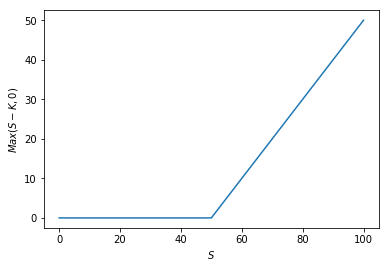

In [34]:
plt.plot(X, Y)
plt.ylabel(r"$Max(S - K, 0)$")
plt.xlabel(r"$S$")
texsave("../images/Call.tex")
plt.show()

## Symmetric Random Walk

In [2]:
symmetric_random_walk = lambda nsteps: np.cumsum(np.append(0, choice([-1,1], nsteps)))

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter
Please add the following lines to your LaTeX preamble:

\usepackage[utf8]{inputenc}
\usepackage{fontspec} % This line only for XeLaTeX and LuaLaTeX
\usepackage{pgfplots}


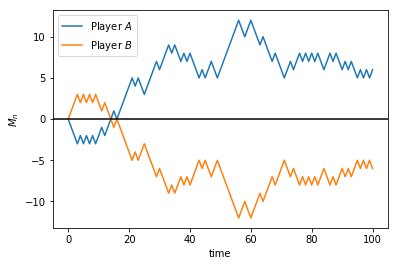

In [77]:
rwalk_sample = symmetric_random_walk(100)
plt.plot(rwalk_sample, label="Player $A$")
plt.plot(-rwalk_sample, label="Player $B$")
plt.axhline(y=0, xmin=0, xmax=100, color="black")
plt.xlabel("time")
plt.ylabel("$M_n$")
plt.legend(loc="best")
texsave("../images/symmetric_random_walk.tex")
plt.show()

## Scaled Random Walk

In [3]:
scaled_random_walk  = lambda partitions, t: symmetric_random_walk(partitions * t) / sqrt(partitions)

In [4]:
seed(1643)

breaks = 1000
RW = pd.DataFrame()
partitions = [1, 10, 20, 500]

rw = scaled_random_walk(breaks, 1)
for partition in partitions:
    new_scale = int(breaks / partition)
    rw_new = scaled_random_walk(new_scale, 1)
    rw_new_rows = np.array([i * partition for i in range(new_scale + 1)])
    
    RW.ix[rw_new_rows, "N = {}".format(new_scale)] = rw_new
    
RW.index = np.linspace(0, 1, breaks + 1)
RW.ffill(inplace=True)

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter
Please add the following lines to your LaTeX preamble:

\usepackage[utf8]{inputenc}
\usepackage{fontspec} % This line only for XeLaTeX and LuaLaTeX
\usepackage{pgfplots}


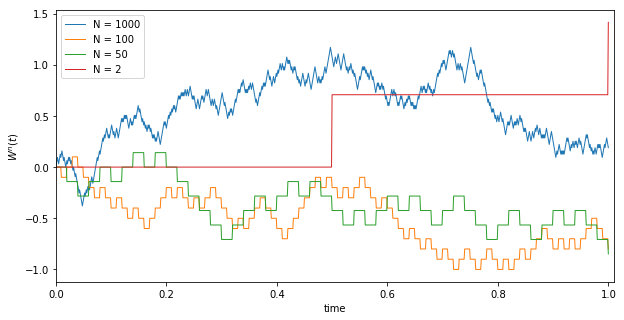

In [13]:
%matplotlib inline
RW.plot(linewidth=1, figsize=(10,5))
plt.xlabel("time")
plt.ylabel("$W^n(t)$")
plt.xlim(0, 1.01);
texsave("../images/scaled_random_walk.tex")